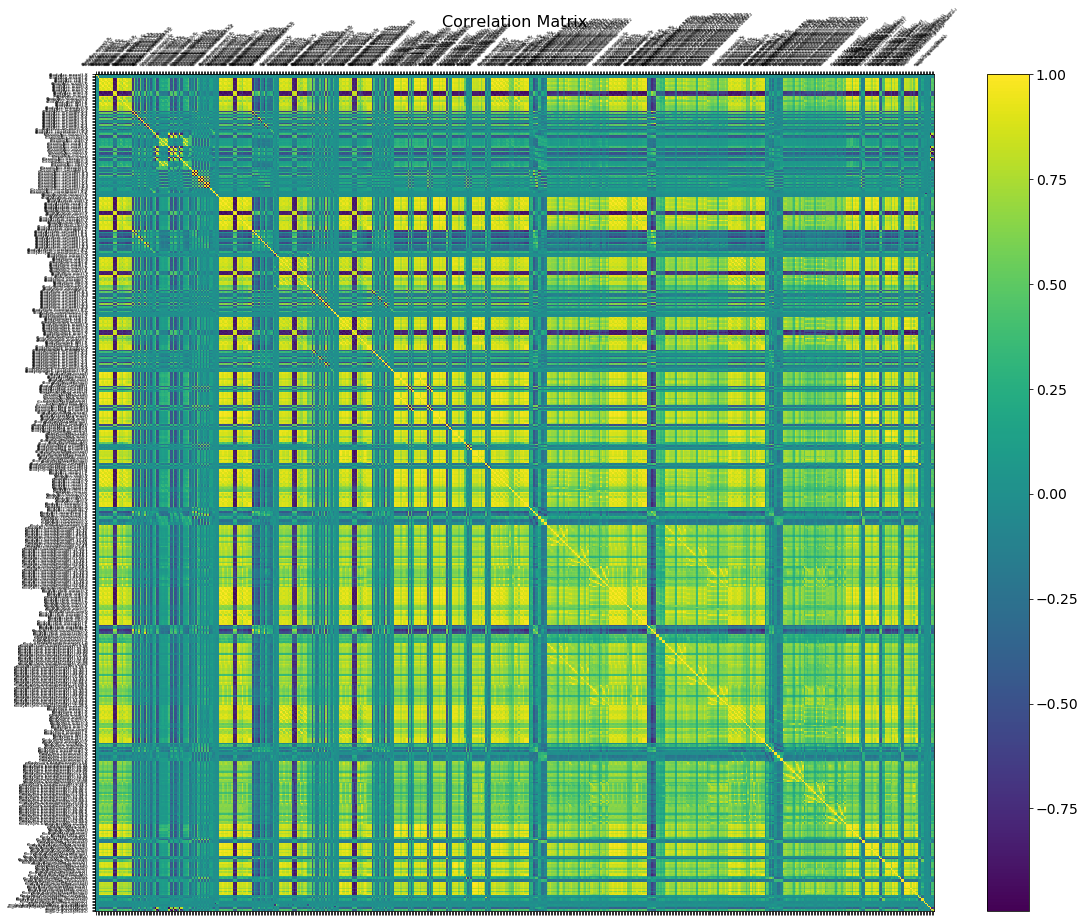

(7352, 107)
(2947, 107)
{'criterion': 'gini', 'max_depth': 7}
Accuracy on train set: 0.9464091403699674
Accuracy on test set: 0.8517136070580251
Confusion Matrix Decision Tree for train set:
 [[1406    0    0    0    1    0]
 [   0 1164  122    0    0    0]
 [   0   72 1302    0    0    0]
 [   0    0    0 1162   37   27]
 [   0    0    0   14  939   33]
 [   0    1    0   19   68  985]]
Confusion Matrix Decision Tree for test set:
 [[537   0   0   0   0   0]
 [  0 367 124   0   0   0]
 [  0  65 467   0   0   0]
 [  0   0   0 424  58  14]
 [  0   0   0  29 346  45]
 [  0   0   0  49  53 369]]
Report on train set:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00      1407
           SITTING       0.94      0.91      0.92      1286
          STANDING       0.91      0.95      0.93      1374
           WALKING       0.97      0.95      0.96      1226
WALKING_DOWNSTAIRS       0.90      0.95      0.92       986
  WALKING_UPSTAIR

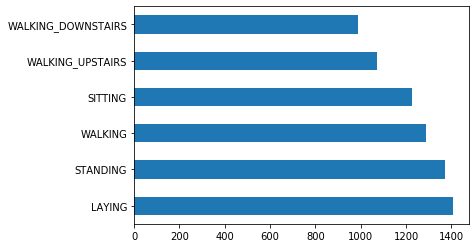

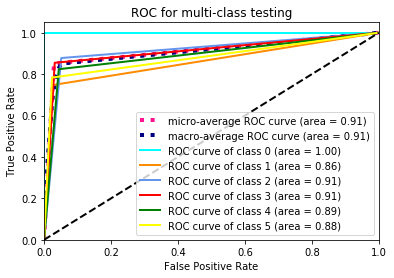

AUC for Laying vs the rest:  0.9996446339729922
AUC for Sitting vs the rest:  0.9465489516818367
AUC for Standing vs the rest:  0.9635950450049015
AUC for Walking vs the rest:  0.9712054202689683
AUC for Walking Downstairs vs the rest:  0.9678408494926457
AUC for Walking Upstairs vs the rest:  0.9542156453700681


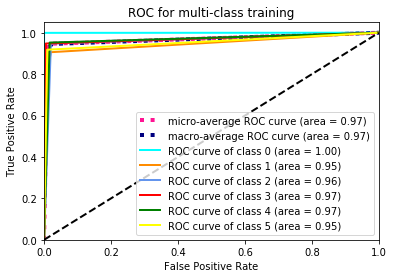

In [11]:
import pandas as pd
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle


#load dataset
dfTrain=pd.read_csv("C:/Dataset//train.csv")
dfTest=pd.read_csv("C://Dataset//test.csv")

#corrplot
independent_train=dfTrain.drop(["Activity","subject"],axis=1)
corrplot = independent_train.corr().abs()
upper=corrplot.where(np.triu(np.ones(corrplot.shape),k=1).astype(np.bool))
to_drop=[column for column in upper.columns if any(upper[column]>0.70)]


'''
Print to text for offline analysis

#so_range_string=so_range.to_string()
#file=open('575_highcor_DT.txt',"a")
#file.write(so_range_string)
#file.close()


#file=open('575project_DT.txt',"a")
#corrplot_string=corrplot.to_string()
#file.write(corrplot_string)
#file.close()
'''
#Plot of Corrplot
f = plt.figure(figsize=(19, 15))
plt.matshow(independent_train.corr(), fignum=f.number)
plt.xticks(range(independent_train.shape[1]), independent_train.columns, fontsize=4, rotation=45)
plt.yticks(range(independent_train.shape[1]), independent_train.columns, fontsize=4)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()



#training dataset
colnamesTrain=list(dfTrain.columns)
colnamesX_train=colnamesTrain[:-2]
Xtrain=independent_train.drop(independent_train[to_drop],axis=1)
ytrain=dfTrain.Activity
print(Xtrain.shape)
#testing dataset
colnamesTest=list(dfTest.columns)
colnamesX_test=colnamesTest[:-2]
independent_test=dfTest.drop(["Activity","subject"],axis=1)
Xtest=independent_test.drop(independent_test[to_drop],axis=1)
ytest=dfTest.Activity
print(Xtest.shape)
#plot number of Activity  in training
dfTrain['Activity'].value_counts().plot(kind='barh')
dfTest['Activity'].value_counts().plot(kind='barh')

'''
#Grid Search
def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = {'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
    # decision tree model
    dtree_model=DecisionTreeClassifier(random_state=0)
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid,cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

print(dtree_grid_search(Xtrain,ytrain,5))
'''

#create decision tree object
clf=DecisionTreeClassifier(criterion= 'gini', max_depth= 7,random_state=0)

#Train decision tree classifer
clf=clf.fit(Xtrain,ytrain)

#variable importance
variable_import=dict(zip(dfTrain.columns, clf.feature_importances_))
listOfKeys = [key  for (key, value) in variable_import.items() if value == 0.0]

#Predict the response for train dataset
ypred_train = clf.predict(Xtrain)

#Predict the response for test dataset
ypred_test = clf.predict(Xtest)

# Model Accuracy, how often is the classifier correct?
print("Accuracy on train set:",metrics.accuracy_score(ytrain, ypred_train))
print("Accuracy on test set:",metrics.accuracy_score(ytest, ypred_test))

#Confusion matrix on train set
confusionMatrix_DT_train=confusion_matrix(ytrain,ypred_train)
print("Confusion Matrix Decision Tree for train set:\n",confusionMatrix_DT_train)

#Confusion matrix on test set
confusionMatrix_DT_test=confusion_matrix(ytest,ypred_test)
print("Confusion Matrix Decision Tree for test set:\n",confusionMatrix_DT_test)

#Classification report
print("Report on train set:\n", classification_report(ytrain, ypred_train))
print("Report on test set:\n", classification_report(ytest, ypred_test))

#ROC on test
ytest_lb = label_binarize(ytest, classes=['LAYING','SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])
n_classes = ytest_lb.shape[1]
ypred_test_lb=label_binarize(ypred_test, classes=['LAYING','SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_lb[:, i], ypred_test_lb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ytest_lb.ravel(), ypred_test_lb.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#ROC curve for a specific class
print("AUC for Laying vs the rest: ",roc_auc[0])
print("AUC for Sitting vs the rest: ",roc_auc[1])
print("AUC for Standing vs the rest: ",roc_auc[2])
print("AUC for Walking vs the rest: ",roc_auc[3])
print("AUC for Walking Downstairs vs the rest: ",roc_auc[4])
print("AUC for Walking Upstairs vs the rest: ",roc_auc[5])

#Plot ROC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','green','yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class testing')
plt.legend(loc="lower right")
plt.show()

#ROC on train
ytrain_lb = label_binarize(ytrain, classes=['LAYING','SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])
n_classes_train = ytrain_lb.shape[1]
ypred_train_lb=label_binarize(ypred_train, classes=['LAYING','SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i in range(n_classes_train):
    fpr_train[i], tpr_train[i], _ = roc_curve(ytrain_lb[:, i], ypred_train_lb[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Compute micro-average ROC curve and ROC area
fpr_train["micro"], tpr_train["micro"], _ = roc_curve(ytrain_lb.ravel(), ypred_train_lb.ravel())
roc_auc_train["micro"] = auc(fpr_train["micro"], tpr_train["micro"])

#ROC curve for a specific class
print("AUC for Laying vs the rest: ",roc_auc_train[0])
print("AUC for Sitting vs the rest: ",roc_auc_train[1])
print("AUC for Standing vs the rest: ",roc_auc_train[2])
print("AUC for Walking vs the rest: ",roc_auc_train[3])
print("AUC for Walking Downstairs vs the rest: ",roc_auc_train[4])
print("AUC for Walking Upstairs vs the rest: ",roc_auc_train[5])

#Plot ROC
# First aggregate all false positive rates
all_fpr_train = np.unique(np.concatenate([fpr_train[i] for i in range(n_classes_train)]))

# Then interpolate all ROC curves at this points
mean_tpr_train = np.zeros_like(all_fpr_train)
for i in range(n_classes_train):
    mean_tpr_train += interp(all_fpr_train, fpr_train[i], tpr_train[i])

# Finally average it and compute AUC
mean_tpr_train /= n_classes_train

fpr_train["macro"] = all_fpr_train
tpr_train["macro"] = mean_tpr_train
roc_auc_train["macro"] = auc(fpr_train["macro"], tpr_train["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr_train["micro"], tpr_train["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_train["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_train["macro"], tpr_train["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_train["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','green','yellow'])
for i, color in zip(range(n_classes_train), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_train[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class training')
plt.legend(loc="lower right")
plt.show()